![](../images/banner.png)
[Slides](./slides/semi_implicit_swe.html)

Firedrake is a numerical PDEs framework that uses the Python programming language to solve PDEs that are expressed in weak form.
This is achieved by using automatic code generation to write, compile and run the kernels.
Python is an interpreted object oriented programming language which we can use to express the PDE problem without having to compile the code before running it.

The weak form of the PDE problem, in our case the shallow water equations, first expressed in UFL and then the two stage form compiler (TSFC) takes this along with provided solver options generates, compiles and runs efficient C code to numerically solve the SWE.

# Semi-Implicit Shallow Water Equations

### Spatial discretisation
The linear Shallow Water Equations (SWE), linearised around the "lake at rest" are:
\begin{align}
	\frac{\partial \phi_S}{\partial t} + \nabla\cdot{\boldsymbol{U}}\hspace{5pt}
	&= 0\\
	\frac{\partial \boldsymbol{U}}{\partial t} + \hspace{3pt} \nabla{\phi_S} \hspace{4pt}
	&= -f(k\times \boldsymbol{U})
\end{align}

We collect $\phi_S$ and $\boldsymbol{U}$ into one vector $\boldsymbol{q} = (\phi_S, \boldsymbol{U}^\top)^\top = (\phi_S, U_1, U_2)^\top$ and define the functions
\begin{equation}
	\bar{F}	=
	\begin{pmatrix}
		U_1 & U_2\\
		\phi_S &0\\
		0 & \phi_S
	\end{pmatrix},
	\qquad
	S(\boldsymbol{q}) = \left( 
	\begin{array}{c}
		0\\
		fU_2 \\
		-fU_1
\end{array} \right)
\end{equation}

So we can write the SWE as a conservation law:
\begin{equation}
	\frac{\partial \boldsymbol{q}}{\partial t} + \nabla\cdot{F(\boldsymbol{q})} = S(\boldsymbol{q})
\end{equation}

To perform a Discontinuous Galerkin (DG) discretisation, we take $\boldsymbol{q}_h$, an approximation to  $\boldsymbol{q}$, in some discontinuous function space.

We can is multiply this conservation law by a test function $\boldsymbol{p}$, integrate over the domain and integrate by parts once.
We use the Lax-Friedrich numerical flux for the internal boundaries, which is given by
\begin{align}
F^*\left( \boldsymbol{q}_h^-, \boldsymbol{q}_h^+ \right)
&= F^\text{LF}\left( \boldsymbol{q}_h^-, \boldsymbol{q}_h^+ \right)\\
&= \frac{1}{2} \left(  F(\boldsymbol{q}_h^-) + F(\boldsymbol{q}_h^+) \right)\\
&\qquad+ \frac{1}{2} |\tau|\left( \boldsymbol{q}_h^-\otimes\boldsymbol{n}^-
+\boldsymbol{q}_h^+\otimes\boldsymbol{n}^+ \right)
\end{align}
where in this case $\tau = 1$.

Which gives us the weak form: Find $\boldsymbol{q}_h$ such that
\begin{align}
\int_\Omega \frac{\partial \boldsymbol{q}_h}{\partial t}\cdot\boldsymbol{p}
-\bar{F}(\boldsymbol{q}_h):\nabla{\boldsymbol{p}}\ dx&\\
+\int_\Gamma [\bar{F^*}(\boldsymbol{q}_h^-, \boldsymbol{q}_h^+)]
&:[\boldsymbol{p}^-\otimes\boldsymbol{n}^- + \boldsymbol{p}^+\otimes\boldsymbol{n}^+]\ ds\\
&= \int_\Omega S(\boldsymbol{q}_h)\cdot\boldsymbol{p} \ dx,
\end{align}
for all $\boldsymbol{p}$ in the discontinuous function space.

### Time discretisation
The theta method for a general time-dependent problem
\begin{equation}
	\frac{d\boldsymbol{q}}{dt} = f(\boldsymbol{q}, t)
\end{equation}

that we want to solve over some time interval $[0, T]$, using a suitably chosen timestep $\Delta t$, can be written as
\begin{equation}
	\boldsymbol{q}^{(n+1)} + (\theta - 1)\Delta t f(\boldsymbol{q}^{(n+1)}, (n + 1)\Delta t)
	= \boldsymbol{q}^{(n)} + \theta\Delta t f(\boldsymbol{q}^{(n)}, n\Delta t).
\end{equation}

This equation is then solved at every timestep to get the next timestep, until the final time $T$ is reached.
This is achieved by using a simple loop.
The solve can be performed using the solver we set up later.

For the weak form of the SWE we defined, we can further define the four bilinear forms
\begin{align}
\mathcal{M}(\boldsymbol{q}_h, \boldsymbol{p})
&:= \int_\Omega \boldsymbol{q}_h \cdot\boldsymbol{p}\ dx\\
\mathcal{D}(\boldsymbol{q}_h, \boldsymbol{p})
&:= \int_\Omega \bar{F}(\boldsymbol{q}_h):\nabla{\boldsymbol{p}}\ dx\\
\mathcal{F}(\boldsymbol{q}_h, \boldsymbol{p})
&:= \int_\Gamma \left[\bar{F^*}(\boldsymbol{q}_h^-, \boldsymbol{q}_h^+)\right]
:\left[\boldsymbol{p}^-\otimes\boldsymbol{n}^-
+\boldsymbol{p}^+\otimes\boldsymbol{n}^+ \right]\ ds\\
\mathcal{S}(\boldsymbol{q}_h, \boldsymbol{p})
&:= \int_\Omega S(\boldsymbol{q}_h)\cdot\boldsymbol{p} \ dx.
\end{align}

If we use the theta method for timestepping we can write the above weak form as
\begin{equation}
	\left[ \mathcal{M} + (\theta - 1)\Delta t (\mathcal{D} - \mathcal{F} + \mathcal{S}) \right]
        (\boldsymbol{q}_h^{(n+1)}, \boldsymbol{p})\\
	\hspace{8em}= \left[ \mathcal{M} + \theta\Delta t (\mathcal{D} - \mathcal{F} + \mathcal{S}) \right]
        (\boldsymbol{q}_h^{(n)}, \boldsymbol{p}).
\end{equation}

Since the right-hand side of the equation uses the solution at the current timestep $\boldsymbol{q}_h^{(n)}$, which is known data, the whole right-hand side is a linear functional.

## Implementation

To start we hard code various constants that will be used for this script.
We set up the mesh we will solve the SWE on as a periodic square mesh of quadrilaterals over the domain $[0, 4]\times[0, 4]$.

We then set up DG function spaces that use polynomials of at most degree 2.
In the code we name the discontinuous function spaces `Phi` and `U`.
The product function space $\Phi_h\times\mathcal{U}_h$ can also be constructed, which is where the test and trial functions live.
With these functions spaces we can make general functions as well as special test and trial functions, that will allow for the expression of the SWE PDE, which is done using UFL.

In [1]:
%matplotlib notebook

import sys
print(sys.executable)

# If built with static PETSc
import os
os.environ['PETSC_ARCH'] = 'arch-python-linux-x86_64'
os.environ['PETSC_DIR'] = '/home/jack/Documents/petsc'

# If Firedrake installed PETSc
del os.environ['PETSC_ARCH']
del os.environ['PETSC_DIR']

import matplotlib.pyplot as plt
from firedrake.plot import _plot_mult

/home/jack/Documents/firedrake/firedrake/bin/python


In [2]:
from firedrake import *

# Number of elements and degree
elts = 20
degree = 2

# Timestepping parameters
T = 2.0
dt = 1/400
theta = 0.5

In [3]:
# Specify mesh
mesh = PeriodicSquareMesh(elts, elts, 4.0, quadrilateral=True)

# Define function spaces
Phi = FunctionSpace(mesh, 'DG', degree)
U = VectorFunctionSpace(mesh, 'DG', degree)
PhiU = Phi*U

# Initialise functions
phi_s = Function(Phi)
u = Function(U)

q = Function(PhiU)
p = TestFunction(PhiU)
q_next = TrialFunction(PhiU)

UFL:WARNING Discontinuous Lagrange element requested on quadrilateral, creating DQ element.
UFL:WARNING Discontinuous Lagrange element requested on quadrilateral, creating DQ element.


### UFL
The Unified Form Language (UFL) is developed as part of the FEniCS project, but has since been used to express weak forms in other projects, including Firedrake.
Its purpose in the Firedrake toolchain is for expressing weak forms in computer code, it is a Domain Specific Language (DSL) built on top of Python.

UFL itself does not try and solve the problem in weak form, merely express what is written mathematically.
It is then the job of a _form compiler_ to take the mathematical expression and generate the code that will numerically solve the PDE.
The Firedrake form compiler is TSFC.
What form compiling means in practise is that the finite element matrix is assembled and a solver is used to compute the solution.

We use UFL to define the initial condition for the SWE problem and the bilinear form that we must use for timestepping.
We start with an initial condition that is a two dimensional Gaussian bump, centred on the coordinate $(2, 2)$ for the height potential, and 0 for the momentum.
This is given by the functions:
\begin{align}
	\phi_s(\boldsymbol{x}, 0) &= 0.1 \times e^{-8 \left[ (x_1 - 2)^2 + (x_2 - 2)^2 \right]}\\
	\boldsymbol{u}(\boldsymbol{x}, 0) &= \boldsymbol{0}
\end{align}

Compare this to the code, which is almost identical to the mathematical expression.
This demonstrates the power of UFL, one can almost immediately go from a mathematical expression to a representation of the same thing in code.

In [4]:
# Coordinate system
x = SpatialCoordinate(mesh)

# Initial conditions
# Potential
ic = 0.1*exp(-8.0*( (x[0] - 2.0)**2 + (x[1] - 2.0)**2) )
phi_s.interpolate(ic)
# Momentum
u.assign(as_vector([0.0, 0.0]))

# Assign q to values of phi and u
q.sub(0).assign(phi_s)
q.sub(1).assign(u)

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fe18809cd10>, VectorElement(FiniteElement('DQ', quadrilateral, 2), dim=2), name=None, index=1, component=None), Mesh(VectorElement(FiniteElement('DQ', quadrilateral, 1), dim=2), 4)), 20)

UFL is also used to express the weak form that we derived.
Since the left and right of our timestepping equation are so similar, we can use a Python function to return both the bilinear form for the left-hand side and the linear form on the right.

This is seen in the second part of the follwoing code, where `M`, `D`, `F` and `S` correspond to the bilinear forms $\mathcal{M}, \mathcal{D}, \mathcal{F}, \mathcal{S}$ .
The function is called when we set up solvers for this problem.

In [5]:
## Bilinear form
def bilinear_form(q, p, theta, dt):
    phi_s, u = split(q)
    # Mass terms
    M = ( dot(q, p) )*dx
    # Volume integral
    # Source
    f_corriolis = Constant(1E-4)
    source = as_vector([Function(Phi).assign(0.0),\
                        +f_corriolis*u[1],        \
                        -f_corriolis*u[0]         ])
    S = ( dot(source, p) )*dx
    # Flux
    flux = as_matrix([ [u[0],  u[1] ],\
                       [phi_s, 0    ],\
                       [0,     phi_s] ])
    D = ( inner(flux, grad(p)) )*dx
    # Numerical Flux
    n = FacetNormal(mesh)
    tau = Constant(1.0)
    F = inner( avg(flux) + tau*avg(outer(q, n)), 2*avg(outer(p, n)) )*dS
    # Final form(s)
    L = D - F + S
    return M - Constant(theta)*Constant(dt)*L

### PETSc
The Portable, Extensible Toolkit for Scientific Computation (PETSc) is an extensive collection of solvers and a unified set of data structures for vectors and matrices.
It is used by many finite element packages to solve the underlying linear (and non-linear) systems that arise, and Firedrake is no exception.

PETSc itself is written in the C language, although it does have a Python interface.
Firedrake generates C code that uses the PETSc data structures for solving the matrix problems generated by the form compiler.
By using the PETSc data structures, Firedrake has access to PETSc's library of solvers.

PETSc is designed and written to be used in parallel, which means that most solver routines and data structures work in parallel without modification.

Each of the solvers in PETSc's library of solvers can be controlled with a range of options.
These options can either be passed at the command line, or as a dictionary of parameters through Firedrake.
We can also combine together different solvers, that is, they are composable.

PETSc also provides the tools to print out exactly what it is doing at each step of a solve and tools to monitor the convergence of the solve.
This allows for solvers to be tuned to the specific problem, by allowing the tolerances to be tightened or loosened or allowing for more or fewer iterations.

In [6]:
# Basic parameters for CG
params = {'ksp_type': 'cg', 'ksp_atol': 1E-8}

### Preconditioning
We can improve the convergence of our solver by setting a suitable preconditioner.
As we are not guaranteed a symmetric positive definite system matrix using a DG discretisation, the "outer" solver we use is GMRES.
We will halt the GMRES algorithm when the reletive residual error is less than $1\times10^{-8}$.

The GMRES solver is preconditioned using a Schur factorisation, which in PETSc is a type of field splitting preconditioner.
So termed because in the SWE we break apart the system matrix into the potential height and momentum fields.
We explicitly tell PETSc to construct the _full_ Schur complement factorisation, PETSc will allow us to use the upper, lower or diagonal blocks of the factorisation if we want a different preconditioner.

To obtain a diagonal approximation for the momentum block, specified in `fieldsplit_1` parameters, we use a combination of block Jacobi and an incomplete $LU$ factorisation, which results in a diagonal approximation to the inverse of this block.

PETSc never constructs the Schur complement for the other block, which we specify using `fieldsplit_0` paramaters.
Instead the action of the inverse is applied using a solver, in this case we use Algebraic MultiGrid (AMG) as the 'inner' solver.

In [7]:
# Approximate Schur complement preconditioner
params = {  'ksp_type': 'gmres',
            'ksp_rtol': 1E-8,
            'pc_type': 'fieldsplit',
            'pc_fieldsplit_type': 'schur',
            'pc_fieldsplit_schur_fact_type': 'FULL',
            'pc_fieldsplit_schur_precondition': 'selfp',
            'fieldsplit_0': {'ksp_type': 'preonly',
                             'pc_type': 'gamg',
                             'mg_levels': {'ksp_type': 'chebyshev',
                                           'ksp_max_it': 2,
                                           'pc_type': 'bjacobi',
                                           'sub_pc_type': 'sor'}},
            'fieldsplit_1': {'ksp_type': 'preonly',
                             'pc_type': 'bjacobi',
                             'sub_pc_type': 'ilu'}}

In [8]:
# Set the left and right hand sides
a = bilinear_form(q_next, p, theta, dt)
b = bilinear_form(q, p, (theta - 1), dt)

# Setup some solvers to speed things up
q_step = Function(PhiU)
problem = LinearVariationalProblem(a, b, q_step)
solver = LinearVariationalSolver(problem, solver_parameters=params)

### Timestepping
Firedrake does not provide general purpose timesteppers to solve time dependent problems and we must implement our own.
For our numerical experiments we will use the theta method.

The following code demonstrates how the theta method can be implemented.

In [9]:
# Timestep variables
t = 0
step = 0

# Notebook output
phi_fn = Function(Phi)
phi_fn, u_fn = q.split()
output_list = [Function(phi_fn)]

In [10]:
# Output file
#outfile = File('output/swe.pvd')
#phi_fn = Function(Phi)
#u_fn = Function(U)
#phi_fn, u_fn = q.split()
#phi_fn.rename('potential')
#u_fn.rename('momentum')
#outfile.write(phi_fn, u_fn, time=t)

In [11]:
# Timestepping loop
while t <= T:
    solver.solve()
    q.assign(q_step)
    t += dt
    step += 1
    # Write output file every 40 timesteps
    if (step%40 == 0):
        print('{:.2f}'.format(t), end=', ')
        phi_fn, u_fn = q.split()
        #outfile.write(phi_fn, u_fn, time=t)
        output_list.append(Function(phi_fn))

0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00, 1.10, 1.20, 1.30, 1.40, 1.50, 1.60, 1.70, 1.80, 1.90, 2.00, 

### Result
The solution can now be visualised.
We _could_ create a file to save the output and write the initial condition to this file.
In the timestepping loop, every 40 timesteps we save the solution at the current timestep to a list, we could save this to a file instead.
Firedrake supports writing VTK files, that can be visualised using the Paraview tool.

By outputting the timesteps of the simulation, it is possible to check the solution.
Here we can see the ripples radiating from the centre of the domain, $(2, 2)$, which is where the initial Gaussian was centred.
A view of the output can be seen below.

<IPython.core.display.Javascript object>


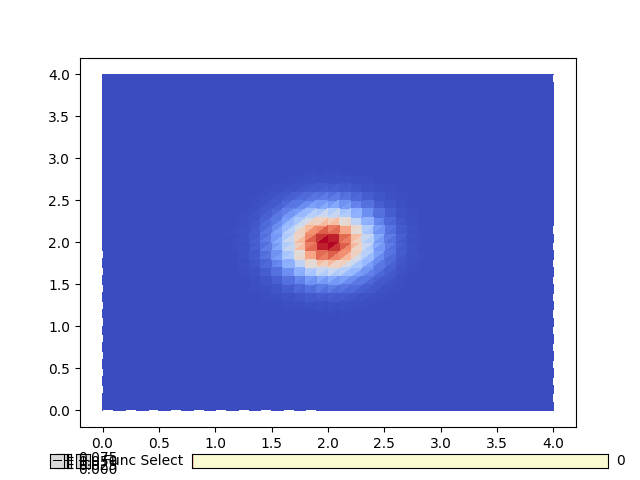

In [12]:
ax = _plot_mult(output_list)

<center><video style="width:80%" autoplay=True loop=True controls src="../images/center.mp4" /></center>